# Grid Search for finding best (D, delta) pair

**Import packages**

In [1]:
from __future__ import division, print_function
import numpy as np
from fatiando.constants import G, MEAN_EARTH_RADIUS, SI2MGAL, SI2EOTVOS
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando import gridder
import matplotlib
import matplotlib.pyplot as plt
# This is our custom tesseroid code
from tesseroid_density import tesseroid

# Thick Shell - Exponential Density

**Analytical solution for exponential density spherical shell**

In [134]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [135]:
top, bottom = 0, -35000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [136]:
shape = (10, 10)
lats, lons, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

**Definition of exponential density function**

In [137]:
rho0, rho1 = 2670, 3300
b = 1e3
a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
c = rho0 - a
deltah = MEAN_EARTH_RADIUS

def density_exponential(height):
    return a*np.exp(-height/b) + c

model.addprop("density", [density_exponential for i in range(model.size)])

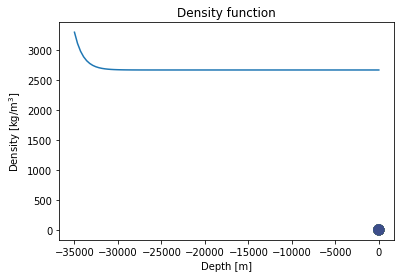

In [138]:
plt.plot(np.linspace(bottom, top, 101),
         density_exponential(np.linspace(bottom, top, 101)))
plt.title("Density function")
plt.ylabel("Density [kg/m$^3$]")
plt.xlabel("Depth [m]")
plt.show()

**Grid Search**

In [139]:
fields = 'potential gz gzz'.split()
delta_values = np.logspace(-3, 0, 7)
D_arrays = [np.arange(0.5, 3, 0.5),
            np.arange(0.5, 5, 0.5),
            np.arange(1, 11, 1)]

fields = [fields[-1]]
D_arrays = [D_arrays[-1]]
            

analytical = shell_exponential_density(heights[0],
                                       top, bottom,
                                       a, b, c, deltah)

for field, D_values in zip(fields, D_arrays):
    print("field:", field)
    errors = []
    for delta in delta_values:
        print("delta:", delta)
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights,
                                               model, delta=delta, ratio=D)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            errors.append(diff)

    shape = (len(delta_values), len(D_values))    
    errors = np.array(errors)
    errors = errors.reshape(shape)
    D_grid, delta_grid = np.meshgrid(D_values, delta_values)
    np.savez('results/grid-search/' + field + '-thick-differences.npz',
             errors=errors, D_grid=D_grid, delta_grid=delta_grid)

field: gzz
delta: 0.001
delta: 0.00316227766017
delta: 0.01
delta: 0.0316227766017
delta: 0.1
delta: 0.316227766017
delta: 1.0


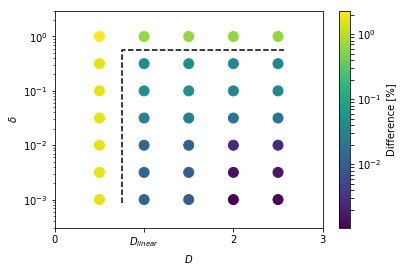

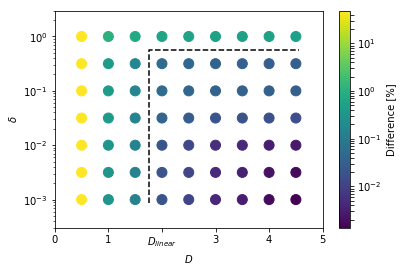

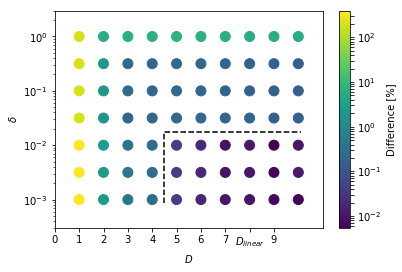

In [141]:
fields = 'potential gz gzz'.split()
axes_aspects = [6, 6, 6]
Ds_linear = [1, 2, 8]

for field, axe_aspect, D_linear in zip(fields, axes_aspects, Ds_linear):
    data = np.load('results/grid-search/' +
                   field + '-thick-differences.npz')
    D_grid, delta_grid = data['D_grid'], data['delta_grid']
    errors = data['errors']
    
    # Plot bigger points if error <= 0.1
    plot_sizes = False
    size = 100
    if plot_sizes:
        sizes = size*np.ones_like(errors)
        sizes[errors<=0.1] = 3*size
    else:
        sizes = size
    cm = plt.scatter(D_grid.ravel(), delta_grid.ravel(),
                     s=sizes, c=errors.ravel(),
                     norm=matplotlib.colors.LogNorm())
    
    # Bellow error points contour
    D_step = abs((D_grid.max() - D_grid.min())/(D_grid.shape[1] - 1))
    delta_factor = abs(delta_grid.max()/delta_grid.min())**(1/(delta_grid.shape[0] - 1))
    min_D = np.min(D_grid[errors <= 0.1]) - D_step/2
    max_D = D_grid.max() + D_step/8
    min_delta = delta_grid.min()*(delta_factor**(-0.125))
    max_delta = np.max(delta_grid[errors <= 0.1])*(delta_factor**0.5)
    plt.plot([min_D, min_D, max_D],
             [min_delta, max_delta, max_delta],
             '--', color='k')
    
    plt.colorbar(cm, label='Difference [%]')
    plt.ylabel("$\delta$")
    plt.xlabel("$D$")
    plt.axes().set_xticks(np.arange(0, 10, 1))
    plt.xlim(D_grid.min() - D_step,
             D_grid.max() + D_step)
    plt.ylim(3e-4, 3e0)
    plt.yscale('log')
    plt.axes().set_aspect(axe_aspect)
    
    plt.draw()
    
    labels = [item.get_text() for item in plt.axes().get_xticklabels()]
    for i in range(len(labels)):
        try:
            if float(labels[i]) == D_linear:
                labels[i] = "$D_{linear}$"
        except:
            continue
    plt.axes().set_xticklabels(labels)
    
    plt.show()